# MemN으로 질의 응답(Question Answering) 구현

In [1]:
# ! pip install customized_konlpy

In [2]:
from ckonlpy.tag import Twitter
from tensorflow.keras.utils import get_file
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
from nltk import FreqDist
from functools import reduce
import os
import re
import matplotlib.pyplot as plt

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

### 데이터 가져오기

In [4]:
# 한국어 bAbi 데이터셋
# 훈련 데이터 : https://bit.ly/31SqtHy
# 테스트 데이터 : https://bit.ly/3f7rH5g

# 영어 bAbi(pronounced “baby") 데이터셋
# from tensorflow.keras.utils import get_file
# import tarfile

# path = get_file('babi-tasks-v1-2.tar.gz', origin='https://s3.amazonaws.com/text-datasets/'
#                 'babi_tasks_1-20_v1-2.tar.gz')
# with tarfile.open(path) as tar:
#     tar.extractall()
#     tar.close()

In [5]:
import tarfile
path = get_file('babi-tasks-v1-2.tar.gz', origin='https://s3.amazonaws.com/text-datasets/'
                'babi_tasks_1-20_v1-2.tar.gz')
with tarfile.open(path) as tar:
    tar.extractall()
    tar.close()

DATA_DIR = 'tasks_1-20_v1-2/en-10k'
TRAIN_FILE = os.path.join(DATA_DIR, "qa1_single-supporting-fact_train.txt")
TEST_FILE = os.path.join(DATA_DIR, "qa1_single-supporting-fact_test.txt")

In [6]:
# TRAIN_FILE = os.path.join("/content/drive/My Drive/NLP_LAB/qa1_single-supporting-fact_train.txt")
# TEST_FILE = os.path.join("/content/drive/My Drive/NLP_LAB/qa1_single-supporting-fact_test.txt")

In [7]:
i = 0
lines = open(TRAIN_FILE , "rb")
for line in lines:
    line = line.decode("utf-8").strip()
    i = i + 1
    print(line)
    if i == 20:
        break        

1 Mary moved to the bathroom.
2 John went to the hallway.
3 Where is Mary? 	bathroom	1
4 Daniel went back to the hallway.
5 Sandra moved to the garden.
6 Where is Daniel? 	hallway	4
7 John moved to the office.
8 Sandra journeyed to the bathroom.
9 Where is Daniel? 	hallway	4
10 Mary moved to the hallway.
11 Daniel travelled to the office.
12 Where is Daniel? 	office	11
13 John went back to the garden.
14 John moved to the bedroom.
15 Where is Sandra? 	bathroom	8
1 Sandra travelled to the office.
2 Sandra went to the bathroom.
3 Where is Sandra? 	bathroom	2
4 Mary went to the bedroom.
5 Daniel moved to the hallway.


### 데이터 전처리

In [8]:
def read_data(dir):
    stories, questions, answers = [], [], [] # 각각 스토리, 질문, 답변을 저장할 예정
    story_temp = [] # 현재 시점의 스토리 임시 저장
    lines = open(dir, "rb")

    for line in lines:
        line = line.decode("utf-8") # b' 제거
        line = line.strip() # '\n' 제거
        idx, text = line.split(" ", 1) # 맨 앞에 있는 id number 분리
        # 여기까지는 모든 줄에 적용되는 전처리

        if int(idx) == 1:
            story_temp = []

        if "\t" in text: # 현재 읽는 줄이 질문 (tab) 답변 (tab)인 경우
            question, answer, _ = text.split("\t") # 질문과 답변을 각각 저장
            stories.append([x for x in story_temp if x]) # 지금까지의 누적 스토리를 스토리에 저장
            questions.append(question)
            answers.append(answer)

        else: # 현재 읽는 줄이 스토리인 경우
            story_temp.append(text) # 임시 저장

    lines.close()
    return stories, questions, answers

In [9]:
train_data = read_data(TRAIN_FILE)
test_data = read_data(TEST_FILE)

In [10]:
train_stories, train_questions, train_answers = read_data(TRAIN_FILE)
test_stories, test_questions, test_answers = read_data(TEST_FILE)
# train_stories, train_questions, train_answers

In [11]:
print('훈련용 스토리의 개수 :', len(train_stories))
print('훈련용 질문의 개수 :',len(train_questions))
print('훈련용 답변의 개수 :',len(train_answers))
print('테스트용 스토리의 개수 :',len(test_stories))
print('테스트용 질문의 개수 :',len(test_questions))
print('테스트용 답변의 개수 :',len(test_answers))

훈련용 스토리의 개수 : 10000
훈련용 질문의 개수 : 10000
훈련용 답변의 개수 : 10000
테스트용 스토리의 개수 : 1000
테스트용 질문의 개수 : 1000
테스트용 답변의 개수 : 1000


In [12]:
train_stories[3572]  # 질문1개 마다 누적 저장되어 있음

['John travelled to the kitchen.',
 'Mary travelled to the office.',
 'Daniel journeyed to the hallway.',
 'John went back to the office.',
 'Sandra went to the office.',
 'Sandra moved to the bedroom.']

In [13]:
train_questions[3572]

'Where is John? '

In [14]:
train_answers[3572]

'office'

### 토큰화

In [15]:
from nltk.tokenize import word_tokenize

def tokenize(sent):
    return word_tokenize(sent)

In [16]:
def preprocess_data(train_data, test_data):
    counter = FreqDist()

    # 두 문장의 story를 하나의 문장으로 통합하는 함수
    flatten = lambda data: reduce(lambda x, y: x + y, data)

    # 각 샘플의 길이를 저장하는 리스트
    story_len = []
    question_len = []

    for stories, questions, answers in [train_data, test_data]:
        for story in stories:
            stories = tokenize(flatten(story)) # 스토리의 문장들을 펼친 후 토큰화
            story_len.append(len(stories)) # 각 story의 길이 저장
            for word in stories: # 단어 집합에 단어 추가
                counter[word] += 1
        for question in questions:
            question = tokenize(question)
            question_len.append(len(question))
            for word in question:
                counter[word] += 1
        for answer in answers:
            answer = tokenize(answer)
            for word in answer:
                counter[word] += 1

    # 단어 집합 생성
    word2idx = {word : (idx + 1) for idx, (word, _) in enumerate(counter.most_common())}
    idx2word = {idx : word for word, idx in word2idx.items()}

    # 가장 긴 샘플의 길이
    story_max_len = np.max(story_len)
    question_max_len = np.max(question_len)

    return word2idx, idx2word, story_max_len, question_max_len

In [17]:
word2idx, idx2word, story_max_len, question_max_len = preprocess_data(train_data, test_data)

In [18]:
print(word2idx)

{'to': 1, 'the': 2, 'went': 3, 'travelled': 4, 'journeyed': 5, 'back': 6, 'moved': 7, '.': 8, 'Where': 9, 'is': 10, '?': 11, 'Sandra': 12, 'John': 13, 'Mary': 14, 'Daniel': 15, 'bathroom': 16, 'garden': 17, 'office': 18, 'kitchen': 19, 'hallway': 20, 'bedroom': 21, 'hallway.John': 22, 'office.Sandra': 23, 'bathroom.John': 24, 'garden.Daniel': 25, 'garden.John': 26, 'bathroom.Sandra': 27, 'bedroom.Mary': 28, 'kitchen.Daniel': 29, 'bedroom.Daniel': 30, 'bedroom.Sandra': 31, 'hallway.Daniel': 32, 'office.Mary': 33, 'garden.Sandra': 34, 'kitchen.Mary': 35, 'bathroom.Mary': 36, 'kitchen.Sandra': 37, 'kitchen.John': 38, 'hallway.Sandra': 39, 'office.Daniel': 40, 'hallway.Mary': 41, 'garden.Mary': 42, 'office.John': 43, 'bedroom.John': 44, 'bathroom.Daniel': 45}


In [19]:
vocab_size = len(word2idx) + 1
print(vocab_size)

46


In [20]:
print('스토리의 최대 길이 :',story_max_len)
print('질문의 최대 길이 :',question_max_len)

스토리의 최대 길이 : 50
질문의 최대 길이 : 4


### 벡터화

In [21]:
def vectorize(data, word2idx, story_maxlen, question_maxlen):
    Xs, Xq, Y = [], [], []
    flatten = lambda data: reduce(lambda x, y: x + y, data)

    stories, questions, answers = data
    for story, question, answer in zip(stories, questions, answers):
        xs = [word2idx[w] for w in tokenize(flatten(story))]
        xq = [word2idx[w] for w in tokenize(question)]
        Xs.append(xs)
        Xq.append(xq)
        Y.append(word2idx[answer])

        # 스토리와 질문은 각각의 최대 길이로 패딩
        # 정답은 원-핫 인코딩
    return pad_sequences(Xs, maxlen=story_maxlen),\
           pad_sequences(Xq, maxlen=question_maxlen),\
           to_categorical(Y, num_classes=len(word2idx) + 1)

In [22]:
Xstrain, Xqtrain, Ytrain = vectorize(train_data, word2idx, story_max_len, question_max_len)
Xstest, Xqtest, Ytest = vectorize(test_data, word2idx, story_max_len, question_max_len)

In [23]:
print(Xstrain.shape, Xqtrain.shape, Ytrain.shape, Xstest.shape, Xqtest.shape, Ytest.shape)
Xstrain[:3], Xqtrain[:3], Ytrain[:3]

(10000, 50) (10000, 4) (10000, 46) (1000, 50) (1000, 4) (1000, 46)


(array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0, 14,  7,  1,  2, 24,  3,  1,  2,
         20,  8],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 14,
          7,  1,  2, 24,  3,  1,  2, 32,  3,  6,  1,  2, 39,  7,  1,  2,
         17,  8],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0, 14,  7,  1,  2, 24,  3,  1,  2, 32,
          3,  6,  1,  2, 39,  7,  1,  2, 26,  7,  1,  2, 23,  5,  1,  2,
         16,  8]]),
 array([[ 9, 10, 14, 11],
        [ 9, 10, 15, 11],
        [ 9, 10, 15, 11]]),
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

### 학습 모델 구현

In [24]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Permute, dot, add, concatenate
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Activation

In [25]:
train_epochs = 120   # 에포크 횟수
batch_size = 32      # 배치 크기
embed_size = 50      # 임베딩 크기
lstm_size = 64       # LSTM의 크기
dropout_rate = 0.30  # 과적합 방지 기법인 드롭아웃 적용 비율

In [26]:
input_sequence = Input((story_max_len,))
question = Input((question_max_len,))

print('Stories :', input_sequence)
print('Question:', question)

Stories : Tensor("input_1:0", shape=(None, 50), dtype=float32)
Question: Tensor("input_2:0", shape=(None, 4), dtype=float32)


In [27]:
# 스토리를 위한 첫번째 임베딩. 그림에서 Embedding A
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,
                              output_dim=embed_size))
input_encoder_m.add(Dropout(dropout_rate))
# 결과 : (samples, story_max_len, embedding_dim) / 샘플의 수, 문장의 최대 길이, 임베딩 벡터의 차원
input_encoder_m.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 50)          2300      
_________________________________________________________________
dropout (Dropout)            (None, None, 50)          0         
Total params: 2,300
Trainable params: 2,300
Non-trainable params: 0
_________________________________________________________________


In [28]:
# 스토리를 위한 두번째 임베딩. 그림에서 Embedding C
# 임베딩 벡터의 차원을 question_max_len(질문의 최대 길이)로 한다.
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,
                              output_dim=question_max_len))
input_encoder_c.add(Dropout(dropout_rate))
# 결과 : (samples, story_max_len, question_max_len) / 샘플의 수, 문장의 최대 길이, 질문의 최대 길이(임베딩 벡터의 차원)
input_encoder_c.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 4)           184       
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 4)           0         
Total params: 184
Trainable params: 184
Non-trainable params: 0
_________________________________________________________________


In [29]:
# 질문을 위한 임베딩. 그림에서 Embedding B
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=embed_size,
                               input_length=question_max_len))
question_encoder.add(Dropout(dropout_rate))
# 결과 : (samples, question_max_len, embedding_dim) / 샘플의 수, 질문의 최대 길이, 임베딩 벡터의 차원
question_encoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 4, 50)             2300      
_________________________________________________________________
dropout_2 (Dropout)          (None, 4, 50)             0         
Total params: 2,300
Trainable params: 2,300
Non-trainable params: 0
_________________________________________________________________


In [30]:
# 실질적인 임베딩 과정
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

print('Input encoded m', input_encoded_m)
print('Input encoded c', input_encoded_c)
print('Question encoded', question_encoded)

Input encoded m Tensor("sequential/Identity:0", shape=(None, 50, 50), dtype=float32)
Input encoded c Tensor("sequential_1/Identity:0", shape=(None, 50, 4), dtype=float32)
Question encoded Tensor("sequential_2/Identity:0", shape=(None, 4, 50), dtype=float32)


In [31]:
# 스토리 단어들과 질문 단어들 간의 유사도를 구하는 과정
# 유사도는 내적을 사용한다.  어텐션 메커니즘의 의도를 갖고 있다
match = dot([input_encoded_m, question_encoded], axes=-1, normalize=False)
match = Activation('softmax')(match)  # 
print('Match shape', match)
# 결과 : (samples, story_maxlen, question_max_len) / 샘플의 수, 문장의 최대 길이, 질문의 최대 길이

# add the match matrix with the second input vector sequence
response = add([match, input_encoded_c])  # (samples, story_max_len, question_max_len)
response = Permute((2, 1))(response)  # (samples, question_max_len, story_max_len)
print('Response shape', response)

# Permute((2, 1)) : 입력 데이터의 차원의 값을  바꿈, (N,70,5) --> (N,5,70)
# tf.keras.layers.Permute( dims, **kwargs )  # Permutes the dimensions of the input according to a given pattern.
# Permutation pattern does not include the samples dimension. Indexing starts at 1.
# For instance, (2, 1) permutes the first and second dimensions of the input.

# concatenate the response vector with the question vector sequence
answer = concatenate([response, question_encoded])
print('Answer shape', answer)

answer = LSTM(lstm_size)(answer)  # Generate tensors of shape 32
answer = Dropout(dropout_rate)(answer)
answer = Dense(vocab_size)(answer)  # (samples, vocab_size)
# we output a probability distribution over the vocabulary
answer = Activation('softmax')(answer)

Match shape Tensor("activation/Identity:0", shape=(None, 50, 4), dtype=float32)
Response shape Tensor("permute/Identity:0", shape=(None, 4, 50), dtype=float32)
Answer shape Tensor("concatenate/Identity:0", shape=(None, 4, 100), dtype=float32)


In [32]:
# build the final model
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['acc'])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
sequential (Sequential)         multiple             2300        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 4, 50)        2300        input_2[0][0]                    
______________________________________________________________________________________________

In [33]:
# start training the model, 약 4분 소요(CPU)
history = model.fit([Xstrain, Xqtrain],
         Ytrain, batch_size, train_epochs,
         validation_data=([Xstest, Xqtest], Ytest))

# save model
model.save('model.h5') # 모델의 구조, 가중치, 훈련 설정을 하나의 파일에 저장

Train on 10000 samples, validate on 1000 samples
Epoch 1/120
10000/10000 [==============================] - 15s 2ms/sample - loss: 1.9153 - acc: 0.1779 - val_loss: 1.7333 - val_acc: 0.2310
Epoch 2/120
10000/10000 [==============================] - 4s 433us/sample - loss: 1.7070 - acc: 0.2754 - val_loss: 1.6774 - val_acc: 0.3090
Epoch 3/120
10000/10000 [==============================] - 4s 405us/sample - loss: 1.6129 - acc: 0.4187 - val_loss: 1.5630 - val_acc: 0.5260
Epoch 4/120
10000/10000 [==============================] - 4s 394us/sample - loss: 1.5255 - acc: 0.4815 - val_loss: 1.4704 - val_acc: 0.5080
Epoch 5/120
10000/10000 [==============================] - 4s 399us/sample - loss: 1.4540 - acc: 0.4972 - val_loss: 1.4126 - val_acc: 0.5200
Epoch 6/120
10000/10000 [==============================] - 4s 402us/sample - loss: 1.4043 - acc: 0.5061 - val_loss: 1.3598 - val_acc: 0.5200
Epoch 7/120
10000/10000 [==============================] - 4s 393us/sample - loss: 1.3740 - acc: 0.5065 - 

10000/10000 [==============================] - 4s 384us/sample - loss: 0.1522 - acc: 0.9475 - val_loss: 0.1295 - val_acc: 0.9530
Epoch 59/120
10000/10000 [==============================] - 4s 382us/sample - loss: 0.1546 - acc: 0.9487 - val_loss: 0.1431 - val_acc: 0.9500
Epoch 60/120
10000/10000 [==============================] - 4s 377us/sample - loss: 0.1568 - acc: 0.9458 - val_loss: 0.1272 - val_acc: 0.9640
Epoch 61/120
10000/10000 [==============================] - 4s 383us/sample - loss: 0.1470 - acc: 0.9493 - val_loss: 0.1727 - val_acc: 0.9390
Epoch 62/120
10000/10000 [==============================] - 4s 383us/sample - loss: 0.1408 - acc: 0.9525 - val_loss: 0.1245 - val_acc: 0.9550
Epoch 63/120
10000/10000 [==============================] - 4s 375us/sample - loss: 0.1447 - acc: 0.9520 - val_loss: 0.1321 - val_acc: 0.9550
Epoch 64/120
10000/10000 [==============================] - 4s 370us/sample - loss: 0.1417 - acc: 0.9538 - val_loss: 0.1573 - val_acc: 0.9440
Epoch 65/120
10000/

10000/10000 [==============================] - 4s 372us/sample - loss: 0.0518 - acc: 0.9845 - val_loss: 0.0475 - val_acc: 0.9840
Epoch 116/120
10000/10000 [==============================] - 4s 379us/sample - loss: 0.0439 - acc: 0.9856 - val_loss: 0.0489 - val_acc: 0.9800
Epoch 117/120
10000/10000 [==============================] - 4s 379us/sample - loss: 0.0552 - acc: 0.9839 - val_loss: 0.0527 - val_acc: 0.9800
Epoch 118/120
10000/10000 [==============================] - 4s 375us/sample - loss: 0.0507 - acc: 0.9850 - val_loss: 0.0376 - val_acc: 0.9890
Epoch 119/120
10000/10000 [==============================] - 4s 374us/sample - loss: 0.0470 - acc: 0.9854 - val_loss: 0.0445 - val_acc: 0.9840
Epoch 120/120
10000/10000 [==============================] - 4s 370us/sample - loss: 0.0501 - acc: 0.9849 - val_loss: 0.0313 - val_acc: 0.9890


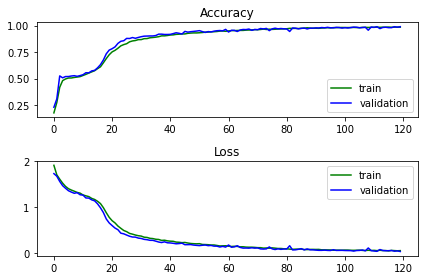

In [34]:
# plot accuracy and loss plot
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="g", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

# labels
ytest = np.argmax(Ytest, axis=1)

# get predictions
Ytest_ = model.predict([Xstest, Xqtest])
ytest_ = np.argmax(Ytest_, axis=1)

In [35]:
# import tensorflow as tf
# new_model = tf.keras.models.load_model('model.h5') # 저장된 모델로부터 새로운 케라스 모델을 로드
# new_model.summary() # 저장했던 모델과 동일

In [36]:
NUM_DISPLAY = 1000

print("{:18}|{:5}|{}".format("질문", "실제값", "예측값"))
print(39 * "-")

correction = 0
for i in range(NUM_DISPLAY):
    question = " ".join([idx2word[x] for x in Xqtest[i].tolist()])
    label = idx2word[ytest[i]]
    prediction = idx2word[ytest_[i]]
    print("{:20}: {:7} {}".format(question, label, prediction))
    if label == prediction:
        correction += 1

질문                |실제값  |예측값
---------------------------------------
Where is John ?     : hallway hallway
Where is Mary ?     : bathroom bathroom
Where is Sandra ?   : kitchen kitchen
Where is Sandra ?   : hallway hallway
Where is Sandra ?   : kitchen kitchen
Where is Sandra ?   : hallway hallway
Where is Sandra ?   : garden  garden
Where is Daniel ?   : hallway hallway
Where is Sandra ?   : office  office
Where is Daniel ?   : office  office
Where is Mary ?     : kitchen kitchen
Where is Mary ?     : garden  garden
Where is Daniel ?   : office  office
Where is Mary ?     : bedroom bedroom
Where is Mary ?     : bedroom bedroom
Where is John ?     : kitchen kitchen
Where is John ?     : garden  garden
Where is John ?     : kitchen kitchen
Where is Daniel ?   : office  office
Where is John ?     : kitchen kitchen
Where is Mary ?     : hallway hallway
Where is John ?     : office  office
Where is John ?     : office  office
Where is Sandra ?   : hallway hallway
Where is Daniel ?   : bedr

In [37]:
accr = correction/NUM_DISPLAY
print('Accuracy:',accr)

Accuracy: 0.989
